In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from models.model_fpgan import FPGANSynthesizer

import ctgan
from sklearn.model_selection import train_test_split
from utils.privacy import normalized_avg_dist
from utils.fidelity import get_predictions, eval_fidelity

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [28]:
data = pd.read_csv("D:/Datasets/epileptic/Epileptic_Seizure_Recognition.csv")
data = data.drop(columns=['Unnamed'])
data.loc[data["y"] > 1 , "y"] = 0
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


In [29]:
#normalized_data=(data-data.mean())/data.std()
data=(data-data.min())/(data.max()-data.min())
data = data[:70000]

In [30]:
target = 'y'

In [31]:
X = data.drop(columns=[target])
y = data[target]

In [32]:
model_ctgan = FPGANSynthesizer(epochs=20, verbose=True)
original_losses, tranformed_privacies, losses = model_ctgan.fit(data)

Epoch 1, Loss G: -2.4373,Loss D: -2.6461
Epoch 2, Loss G: -2.2761,Loss D: -1.9456
Epoch 3, Loss G: -0.2983,Loss D: -1.6921
Epoch 4, Loss G:  2.5278,Loss D: -1.3714
Epoch 5, Loss G:  0.4412,Loss D: -1.6974
Epoch 6, Loss G: -1.0042,Loss D: -0.8484
Epoch 7, Loss G:  0.3494,Loss D: -0.3812
Epoch 8, Loss G: -0.6385,Loss D: -0.8300
Epoch 9, Loss G:  0.0620,Loss D: -0.0128
Epoch 10, Loss G: -0.8437,Loss D:  1.3881
Epoch 11, Loss G: -0.2429,Loss D: -0.0957
Epoch 12, Loss G:  0.4093,Loss D: -1.5221
Epoch 13, Loss G:  1.1274,Loss D: -0.5762
Epoch 14, Loss G:  0.2270,Loss D: -1.7243
Epoch 15, Loss G:  0.6259,Loss D: -3.1288
Epoch 16, Loss G:  1.7731,Loss D: -2.8016
Epoch 17, Loss G:  1.5907,Loss D: -4.7225
Epoch 18, Loss G: -0.1632,Loss D: -3.9830
Epoch 19, Loss G:  0.5005,Loss D: -4.4157
Epoch 20, Loss G: -1.2700,Loss D: -3.2243


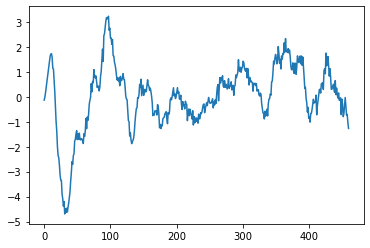

In [33]:
plt.plot(losses)
plt.show()

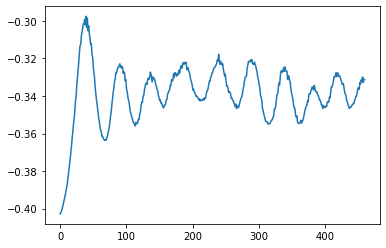

In [34]:
plt.plot(tranformed_privacies)
plt.show()

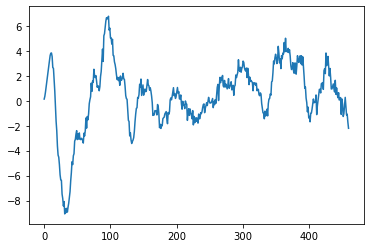

In [35]:
plt.plot(original_losses)
plt.show()

In [36]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

## Privacy

In [37]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame
samples = samples[:2000]
data = data[:2000]

In [38]:
normalized_avg_distance = normalized_avg_dist(samples, data)
print(normalized_avg_distance)

[0.06102769]


## Fidelity

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test)

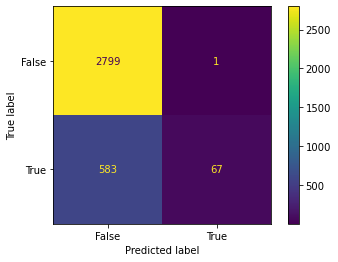

In [40]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred):
    confusion_matrix = metrics.confusion_matrix(rr_pred, fr_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display1.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred)

In [41]:
percentage, same_pred, dif_pred = eval_fidelity(rr_pred, fr_pred)

In [42]:
print(same_pred, dif_pred)

2866 584


## Final plot

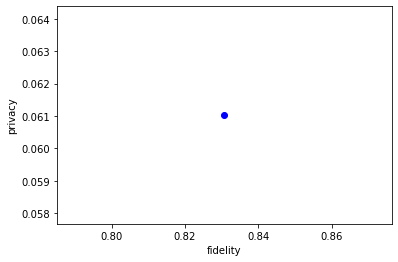

In [43]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()